<a href="https://www.kaggle.com/code/rajatharigasp/mayo-eda?scriptVersionId=103594351" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!conda install ../input/how-to-use-pyvips-offline/*.tar.bz2


######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
###########################

In [2]:
import pyvips
import os

In [3]:
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = '5000000000'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
from openslide import OpenSlide
import random
import gc


Image.MAX_IMAGE_PIXELS = None

In [5]:
train_data = pd.read_csv("../input/mayo-clinic-strip-ai/train.csv")
train_data

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE
...,...,...,...,...,...
749,fe9645_0,3,fe9645,0,CE
750,fe9bec_0,4,fe9bec,0,LAA
751,ff14e0_0,6,ff14e0,0,CE
752,ffec5c_0,7,ffec5c,0,LAA


In [6]:
test_data = pd.read_csv("../input/mayo-clinic-strip-ai/test.csv")
display(test_data)

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0
2,00c058_0,11,00c058,0
3,01adc5_0,11,01adc5,0


In [7]:
patients = len(train_data['patient_id'].value_counts())
centers = len(train_data['center_id'].value_counts())

print("No.of unique patients =",patients)
print("No. of centers =",centers)

No.of unique patients = 632
No. of centers = 11


 Total CE images = 547 
 Total LAA images = 207


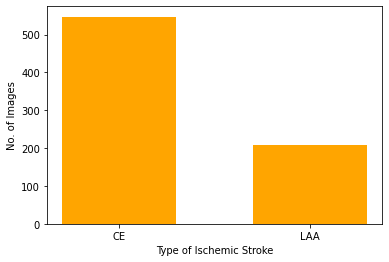

In [8]:
plot = {'CE': len(train_data[train_data['label']=='CE']),'LAA':len(train_data[train_data['label']=='LAA'])}
labels = plot.keys()
values = plot.values()
print(" Total CE images =",plot['CE'],'\n','Total LAA images =',plot['LAA'])
plt.bar(labels, values, width =0.6, color= 'orange')
plt.xlabel("Type of Ischemic Stroke")
plt.ylabel("No. of Images")
plt.show()

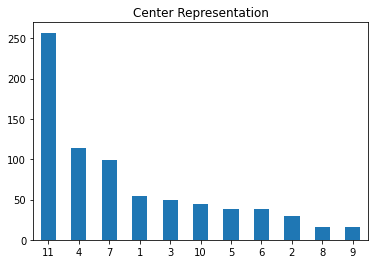

In [9]:
train_data['center_id'].value_counts().plot(kind='bar')
plt.title('Center Representation')
plt.xticks(rotation=360)
plt.show()

In [10]:
train_img = glob.glob("../input/mayo-clinic-strip-ai/train/*")
train_img_pd = pd.DataFrame(columns=['train_path'])
train_img_pd['train_path'] = train_img
train_img_pd['image_id'] = train_img_pd['train_path'].apply(lambda x: x.split('/')[-1].replace('.tif',''))
display(train_img_pd)

,train_path,image_id
0,../input/mayo-clinic-strip-ai/train/a4c7df_0.tif,a4c7df_0
1,../input/mayo-clinic-strip-ai/train/f9fc6b_0.tif,f9fc6b_0
2,../input/mayo-clinic-strip-ai/train/0d718a_0.tif,0d718a_0
3,../input/mayo-clinic-strip-ai/train/86e319_1.tif,86e319_1
4,../input/mayo-clinic-strip-ai/train/54838a_0.tif,54838a_0
...,...,...
749,../input/mayo-clinic-strip-ai/train/5619c3_0.tif,5619c3_0
750,../input/mayo-clinic-strip-ai/train/a1f13b_0.tif,a1f13b_0
751,../input/mayo-clinic-strip-ai/train/43eacb_0.tif,43eacb_0
752,../input/mayo-clinic-strip-ai/train/d1da59_0.tif,d1da59_0


Adding Directory Paths to DF

In [11]:
train_data = train_data.merge(train_img_pd, on='image_id')
train_data

,image_id,center_id,patient_id,image_num,label,train_path
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif
...,...,...,...,...,...,...
749,fe9645_0,3,fe9645,0,CE,../input/mayo-clinic-strip-ai/train/fe9645_0.tif
750,fe9bec_0,4,fe9bec,0,LAA,../input/mayo-clinic-strip-ai/train/fe9bec_0.tif
751,ff14e0_0,6,ff14e0,0,CE,../input/mayo-clinic-strip-ai/train/ff14e0_0.tif
752,ffec5c_0,7,ffec5c,0,LAA,../input/mayo-clinic-strip-ai/train/ffec5c_0.tif


To check the maximum filesize

In [12]:
pix_list = []
pix_id = []

for i in range(len(train_data['patient_id'])):
    img = Image.open(train_data["train_path"][i])
    ht,wt = img.size
    pix = ht*wt
    pix_id.append(train_data['image_id'][i])
    pix_list.append(pix)

In [13]:
inx =  pix_list.index(max(pix_list))
print("Maximum Size of Image Data:")
print('Index no:',inx)
print('ID:',pix_id[inx])
max_gb = max(pix_list)/1024/1024/1024
print('Size:',max_gb,'GB')

Maximum Size of Image Data:
Index no: 329
ID: 6baf51_0
Size: 4.559834014624357 GB


**Displaying Image Using OpenSlide**:
OpenSlide allows us to read Whole-Slide Images(WSI's)

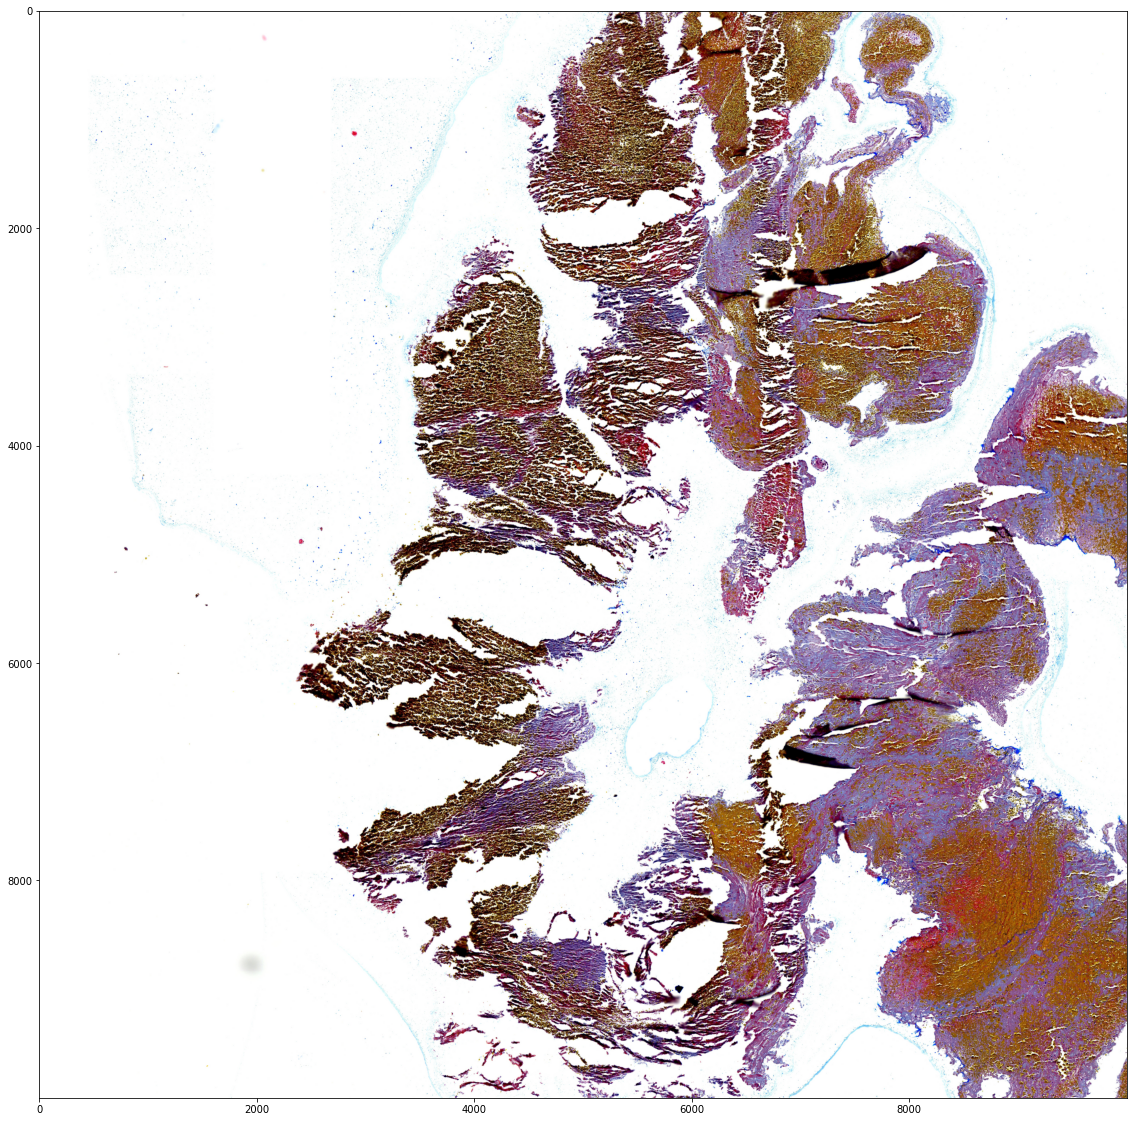

In [14]:
img_path = train_data['train_path'][0]

region = (0, 0)
level = 0
size = (10000, 10000)
    
plt.figure(figsize=(20,20))
slide = OpenSlide(img_path)
plt.imshow(slide.read_region(region, level, size))
plt.show()
   

**Displaying Image Using PIL**

In [15]:
def img_to_array(n):
    image = Image.open(train_data['train_path'][n])
    image = image.resize((300,300))
    image = np.asarray(image)
    image = image.astype(np.uint8)
    return image

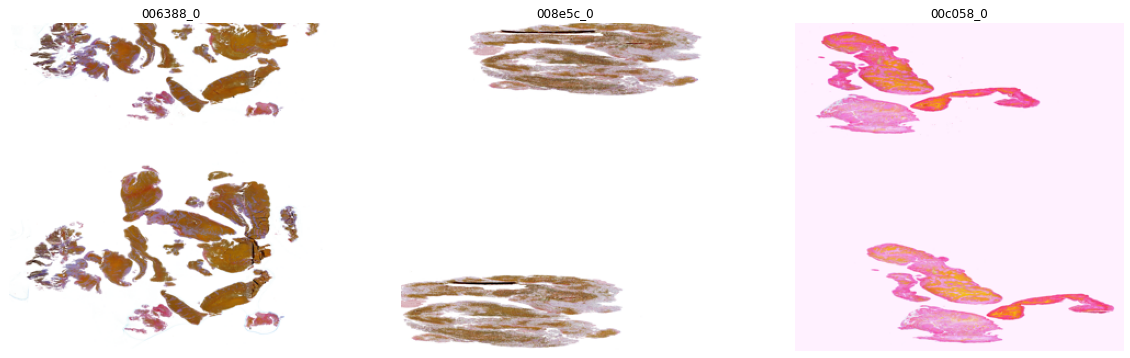

In [16]:
plt.figure(figsize=(20,15))   
for i in range(3):
    img = img_to_array(i)
    plt.subplot(1,3,i+1)
    plt.title(train_data['image_id'][i])
    plt.axis('off')
    plt.imshow(img)

**Displaying Images Using pyvips**: Due to limited RAM on Kaggle, pyvips is one of the memory efficient ways to read the huge .tif files

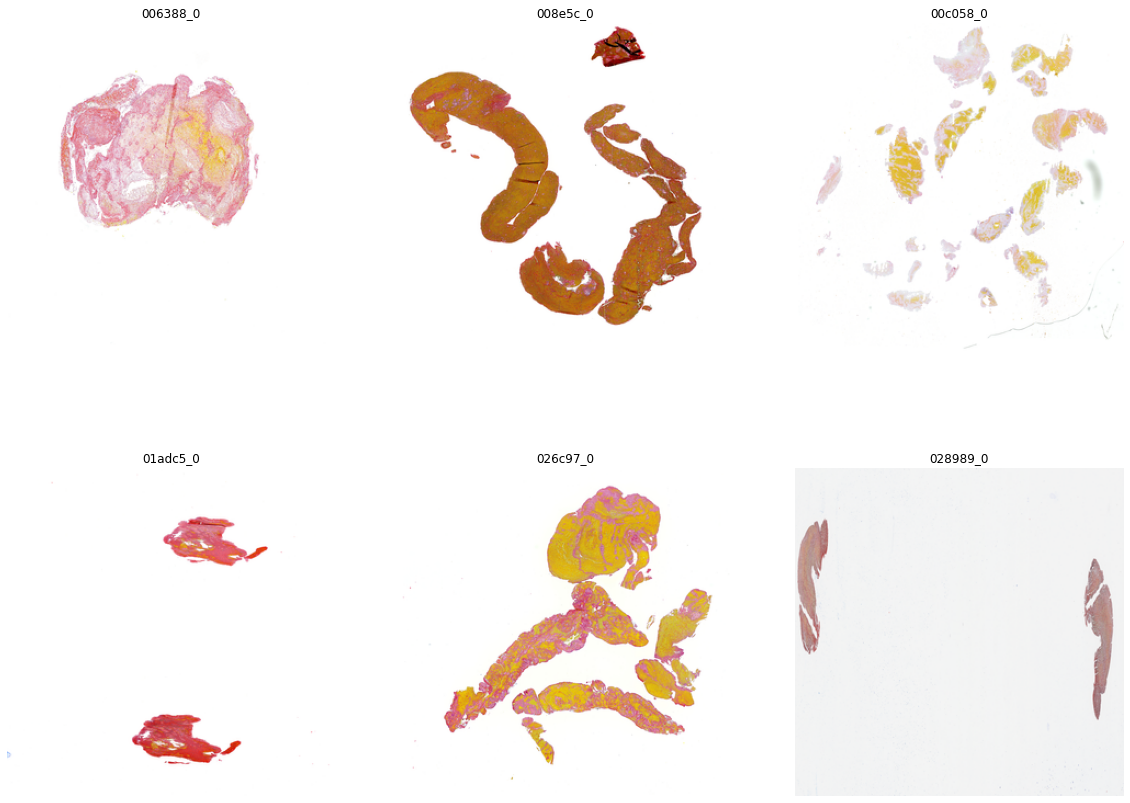

In [17]:
plt.figure(figsize=(20,15)) 
for i in range(6):
    n = random.randint(0,len(train_data))
    img = pyvips.Image.thumbnail(train_data['train_path'][n],300,height=300,size='force')
    plt.subplot(2,3,i+1)
    plt.title(train_data['image_id'][i])
    plt.axis('off')
    plt.imshow(img)
